In [16]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import os
import sys
import plotly.graph_objects as go 
dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')
from labbiofisica import Interpolazione, final_val
from scipy.optimize import curve_fit

In [17]:
filename = 'data/assorbanza_rodamina_concentrazioni_tot.csv'

header = ['λ 5','I 5','λ 4','I 4','no λ 4','no I 4','λ 3','I 3','λ 2','I 2','λ 1','I 1','λ 0.8','I 0.8','λ 0.6','I 0.6','λ 0.4','I 0.4','λ 0.2','I 0.2','λ 0.1','I 0.1']

data = pd.read_csv(filename,sep=',',header=1,nrows=117)
data = data.iloc[:, :-1] # drop last column
data.columns = header
data.tail()

,λ 5,I 5,λ 4,I 4,no λ 4,no I 4,λ 3,I 3,λ 2,I 2,...,λ 0.8,I 0.8,λ 0.6,I 0.6,λ 0.4,I 0.4,λ 0.2,I 0.2,λ 0.1,I 0.1
112,646.950012,29.311554,646.950012,25.126436,646.950012,29.019300,646.950012,21.187140,646.950012,14.265793,...,646.950012,4.883633,646.950012,3.315377,646.950012,1.589167,646.950012,0.555993,646.950012,0.351009
113,647.969971,28.124762,647.969971,23.946281,647.969971,27.984386,647.969971,20.061258,647.969971,13.714191,...,647.969971,4.719029,647.969971,3.173567,647.969971,1.429973,647.969971,0.563877,647.969971,0.378182
114,648.840027,26.902561,648.840027,23.194933,648.840027,27.167797,648.840027,19.790516,648.840027,13.449127,...,648.840027,4.602462,648.840027,3.138167,648.840027,1.417011,648.840027,0.545661,648.840027,0.333807
115,649.849976,26.203035,649.849976,22.347122,649.849976,25.561733,649.849976,18.675690,649.849976,12.785388,...,649.849976,4.334819,649.849976,2.955356,649.849976,1.345403,649.849976,0.519533,649.849976,0.366366
116,650.859985,24.811270,650.859985,21.325739,650.859985,24.539951,650.859985,18.069601,650.859985,12.159359,...,650.859985,4.134296,650.859985,2.907012,650.859985,1.283329,650.859985,0.497435,650.859985,0.298861


In [18]:
λexc = 526 #nm
SIGMA_LAMBDA = 1.5 #nm DICHIARATI DAL COSTRUTTORE
C = [5,4,3,2,1,0.8,0.6,0.4,0.2,0.1] #mM

# Extracting the relevant columns for plotting
WAVELENGHTS = ['λ 5', 'λ 4', 'λ 3', 'λ 2', 'λ 1', 'λ 0.8', 'λ 0.6', 'λ 0.4', 'λ 0.2', 'λ 0.1']
INTENSITIES = ['I 5', 'I 4', 'I 3', 'I 2', 'I 1', 'I 0.8', 'I 0.6', 'I 0.4', 'I 0.2', 'I 0.1']
CONCENTRATIONS=[5,4,3,2,1,0.8,0.6,0.4,0.2,0.1]

In [19]:
fig = go.Figure()

for λ_col, I_col, c in zip(WAVELENGHTS, INTENSITIES,C):
    fig.add_trace(go.Scatter(x=data[λ_col],y= data[I_col],
                    mode='lines',
                    name=f'{c} μM'))

fig.update_layout(
                  xaxis_title='Wavelength (nm)',
                  yaxis_title='Intensity (a.u.)',
                  height=600,
                  width=800,
                  yaxis=dict(range=[0, 1000]),
                  legend=dict(x=0.9, y=0.9),
                  font=dict(size=14))


fig.show()

lo strumento ha un'incertezza su lambda di 1.5nm

In [20]:
for λ_col, I_col in zip(WAVELENGHTS, INTENSITIES):
    Λ = data[λ_col]
    I = data[I_col]
    Λmax = Λ[I.idxmax()]
    print(f'λmax {I_col} = {int(np.round(Λmax))} nm')#, {np.mean(np.diff(Λ))} nm')

λmax I 5 = 554 nm
λmax I 4 = 554 nm
λmax I 3 = 553 nm
λmax I 2 = 552 nm
λmax I 1 = 552 nm
λmax I 0.8 = 551 nm
λmax I 0.6 = 551 nm
λmax I 0.4 = 551 nm
λmax I 0.2 = 552 nm
λmax I 0.1 = 551 nm


In [21]:
# making maximum point interpolation:
def max_fit_parabolic(x, λcenter, a, IMAX): # -a*(x-λcenter)**2 + IMAX
    return -a*(x-λcenter)**2 + IMAX

segue fit parabolico dei picchi dello spettro, vengono considerati solo i 5 punti a destra e 5 a sinistra del punto massimo dello spettro

segue l'estrapolazione del valore di Imax

In [22]:
λcenter_list = []
a_list = []
IMAX_list = []
error_λcenter_list = []
error_a_list = []
error_IMAX_list = []
sigmay = [] # contiene l'errore propagato con x
for λ_col, I_col in zip(WAVELENGHTS, INTENSITIES):
    Λ = data[λ_col]
    I = data[I_col]
    Λmaxcenter = I.idxmax()

    λcenter = Λ[Λmaxcenter] # guess
    IMAX = I.max() # guess
    a = 1 # guess

    xrangemax = Λ[Λmaxcenter-5:Λmaxcenter+5] # 10 points around the max
    yrangemax = I[Λmaxcenter-5:Λmaxcenter+5] # 10 points around the max
    # ---- per considerare errore su lambda di 1.5nm
    # iterazione 0
    popt, pcov = curve_fit(max_fit_parabolic, xrangemax, yrangemax, p0=[λcenter, a, IMAX])
    λcenter, a, IMAX = popt
    error_λcenter, error_a, error_IMAX = np.sqrt(np.diag(pcov))
    # iterazione 1
    dydl = np.abs(-2*a*(λcenter-xrangemax)) # derivata prima rispetto a λ
    sy = dydl*SIGMA_LAMBDA
    popt, pcov = curve_fit(max_fit_parabolic, xrangemax, yrangemax, p0=[λcenter, a, IMAX],sigma=sy)
    λcenter, a, IMAX = popt
    error_λcenter, error_a, error_IMAX = np.sqrt(np.diag(pcov))
    # iterazione 2
    d2ydl2 = np.abs(-2*a) # derivata seconda rispetto a λ
    sy = np.sqrt((dydl*SIGMA_LAMBDA)**2 + (0.5*d2ydl2*SIGMA_LAMBDA**2)) # errore propagato
    popt, pcov = curve_fit(max_fit_parabolic, xrangemax, yrangemax, p0=[λcenter, a, IMAX],sigma=sy)
    λcenter, a, IMAX = popt
    error_λcenter, error_a, error_IMAX = np.sqrt(np.diag(pcov))

    λcenter_list.append(λcenter)
    a_list.append(a)
    IMAX_list.append(IMAX)
    error_λcenter_list.append(error_λcenter)
    error_a_list.append(error_a)
    error_IMAX_list.append(error_IMAX)
    sigmay.append(sy)

# to numpy
λcenter_list = np.array(λcenter_list)
a_list = np.array(a_list)
IMAX_list = np.array(IMAX_list)
error_λcenter_list = np.array(error_λcenter_list)
error_a_list = np.array(error_a_list)
error_IMAX_list = np.array(error_IMAX_list)
sigmay = np.array(sigmay)

max_fit_parabolic_dataframe = pd.DataFrame({'Concentration (μM)': CONCENTRATIONS, 'λcenter': λcenter_list, 'a': a_list, 'IMAX': IMAX_list, 'error_λcenter': error_λcenter_list, 'error_a': error_a_list, 'error_IMAX': error_IMAX_list})
display(max_fit_parabolic_dataframe)


,Concentration (μM),λcenter,a,IMAX,error_λcenter,error_a,error_IMAX
0,5.0,554.044219,2.442431,940.693325,0.274804,0.443226,1.342285
1,4.0,553.742124,2.156915,819.968625,0.285710,0.435038,1.546347
2,3.0,552.758972,1.744154,718.450202,0.067448,0.081499,0.254055
3,2.0,551.865053,1.027011,492.753337,0.074358,0.052306,0.178710
4,1.0,551.494151,0.503627,238.703070,0.147158,0.053501,0.250304
5,0.8,551.279005,0.386982,170.262114,0.137228,0.036855,0.180003
6,0.6,551.307117,0.243386,117.772112,0.080942,0.013286,0.070467
7,0.4,551.090509,0.101588,52.545366,0.128419,0.009120,0.057811
8,0.2,550.856778,0.031331,19.321189,0.203719,0.004558,0.033509
9,0.1,550.925065,0.024793,11.330715,0.231624,0.004218,0.036550


In [23]:
center = np.mean(λcenter_list)
sigma = np.std(λcenter_list)
print('λcenter =', final_val(center, sigma, udm='nm'))
print('NOTA: sigmaLambda dichiarata dal costruttore vale 1.5nm')

λcenter = 551.94 ± 1.11 nm
NOTA: sigmaLambda dichiarata dal costruttore vale 1.5nm


In [24]:
# plotting normalized spectrum (kind of, in the sense that we are not normalizing the area under the curve, but the maximum value of the spectrum)

delta = np.array(λcenter_list) - np.mean(λcenter_list)  # Calculate the average value of λcenter

plt.figure(figsize=(10, 6))

fig = go.Figure()

for λ_col, I_col, c, d in zip(WAVELENGHTS, INTENSITIES,C,delta):
    max = data[I_col].max()
    centered_wavelengths = data[λ_col] - d  # Center the wavelengths around the average λcenter
    fig.add_trace(go.Scatter(x=centered_wavelengths,y= data[I_col]*100/ max,
                    mode='lines',
                    name=f'{c} μM'))

fig.update_layout(
                  xaxis_title='Wavelength (nm)',
                  yaxis_title='Intensity (%)',
                  height=600,
                  width=800,
                  yaxis=dict(range=[0, 100]),
                  legend=dict(x=0.8, y=1),
                  font=dict(size=14))


fig.show()

<Figure size 1000x600 with 0 Axes>

# CONCETRAZIONI

In [ ]:
filename = './data/concentrazioni_rodamina.csv'
filename_ass = './data/'

conc = pd.read_csv(filename,sep=',')
display(conc)

,ass_teo_i,ass_teo_f,ass_emp_i,ass_emp_f,Vi (muL),Vf (muL),concentrazioni (M)
0,0.50,0.40,0.54290,0.398873,2210,3008,3.438560e-06
1,0.40,0.30,0.40000,0.298773,2252,3015,2.575630e-06
2,0.30,0.20,0.30000,0.199005,2000,3015,1.715560e-06
3,0.20,0.10,0.19900,0.099698,1511,3016,8.594650e-07
4,0.10,0.08,0.09900,0.079693,2423,3010,6.870120e-07
5,0.08,0.06,0.08000,0.059987,2251,3002,5.171270e-07
6,0.06,0.04,0.06000,0.040040,2002,3000,3.451720e-07
7,0.04,0.02,0.04004,0.020020,1497,2994,1.725860e-07
8,0.02,0.01,0.02002,0.010027,1504,3003,8.643680e-08


In [26]:
# fit with the exponential 1-exp(-k*C)

def F_C_fit(C,F0,k,y0):
    return F0*(1-np.exp(-k*C)) + y0

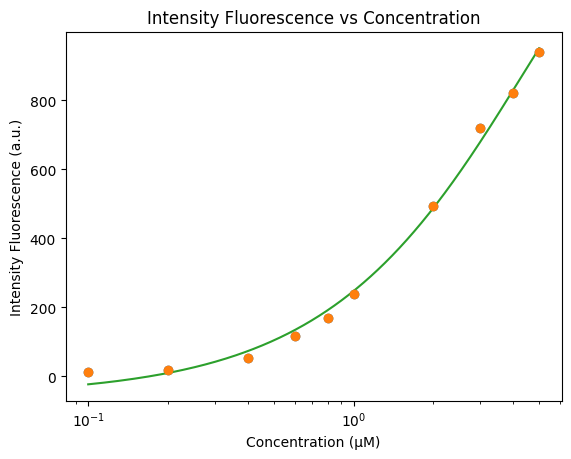

In [27]:
start = 0
I = np.array(IMAX_list)[start:]
sigmaI = np.array(error_IMAX_list)[start:] # need to propagate error on lambda d(-ax^2)/dx = -2ax
sigmaprop = 0 #2*a_list[start:]*center * np.sqrt((error_a_list[start:]/a_list[start:])**2 + (error_λcenter_list[start:]/λcenter_list[start:])**2)
sigmaI = np.sqrt(sigmaI**2 + sigmaprop**2) # propagate error on Imax

C = np.array(CONCENTRATIONS)[start:]

# Fit the data to the model
popt, pcov = curve_fit(F_C_fit, C, I, p0=[1899,0.14,-1.0])
F0, k, y0 = popt
error_F0, error_k, error_y0 = np.sqrt(np.diag(pcov))

plt.plot(C,I,'o',label='data')
plt.errorbar(C,I,yerr=sigmaI,fmt='o')

c = np.linspace(np.min(C),np.max(C),1000)
plt.plot(c,F_C_fit(c,*popt),label='fit')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Concentration (μM)')
plt.ylabel('Intensity Fluorescence (a.u.)')
plt.title('Intensity Fluorescence vs Concentration')
plt.show()